# Retrain a classification model for Edge TPU using post-training quantization (with TF2)

In [7]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import numpy as np
import matplotlib.pyplot as plt

## Prepare the training data

In [8]:
syringe_dir = "./Downloads/Sorted_Sets_2"

In [9]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    syringe_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    syringe_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 316 images belonging to 2 classes.
Found 78 images belonging to 2 classes.


On each iteration, these generators provide a batch of images by reading images from disk and processing them to the proper tensor size (224 x 224). The output is a tuple of (images, labels). For example, you can see the shapes here:

In [10]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 2))

In [11]:
#Save labels to a text file
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('syringe_labels.txt', 'w') as f:
  f.write(labels)

{'clean_dry': 0, 'dirty_wet': 1}


### Build the model
Now we'll create a model that's capable of transfer learning on just the last fully-connected layer.

We'll start with MobileNet V2 from Keras as the base model, which is pre-trained with the ImageNet dataset (trained to recognize 1,000 classes). This provides us a great feature extractor for image classification and we can then train a new classification layer with our flowers dataset.

### Create the base model 

When instantiating the `MobileNetV2` model, we specify the `include_top=False` argument in order to load the network *without* the classification layers at the top. Then we set `trainable` false to freeze all the weights in the base model. This effectively converts the model into a feature extractor because all the pre-trained weights and biases are preserved in the lower layers when we begin training for our classification head.

In [12]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

### Add a classification head

Now we create a new [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model and pass the frozen MobileNet model as the base of the graph, and append new classification layers so we can set the final output dimension to match the number of classes in our dataset (5 types of flowers).

In [20]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=2, activation='softmax') #Change units based on num of labels
])

### Configure the model

Although this method is called `compile()`, it's basically a configuration step that's required before we can start training.

In [21]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

You can see a string summary of the final network with the `summary()` method:

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 2,626,722
Trainable params: 368,738
Non-trainable params: 2,257,984
_________________________________________________________________


And because the majority of the model graph is frozen in the base model, weights from only the last convolution and dense layers are trainable:

In [23]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


## Train the model

In [24]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
5/5 [==============================] - 45s 9s/step - loss: 1.0168 - accuracy: 0.7310 - val_loss: 0.2582 - val_accuracy: 0.8718
Epoch 2/10
5/5 [==============================] - 36s 8s/step - loss: 0.2692 - accuracy: 0.9051 - val_loss: 0.9567 - val_accuracy: 0.6026
Epoch 3/10
5/5 [==============================] - 37s 8s/step - loss: 0.1597 - accuracy: 0.9209 - val_loss: 0.5933 - val_accuracy: 0.6923
Epoch 4/10
5/5 [==============================] - 36s 8s/step - loss: 0.0867 - accuracy: 0.9715 - val_loss: 0.3306 - val_accuracy: 0.8462
Epoch 5/10
5/5 [==============================] - 37s 8s/step - loss: 0.0712 - accuracy: 0.9715 - val_loss: 0.5734 - val_accuracy: 0.8462
Epoch 6/10
5/5 [==============================] - 36s 7s/step - loss: 0.0401 - accuracy: 0.9842 - val_loss: 1.4202 - val_accuracy: 0.7308
Epoch 7/10
5/5 [==============================] - 37s 8s/step - loss: 0.0250 - accuracy: 0.9937 - val_loss: 1.0960 - val_accuracy: 0.8205
Epoch 8/10
5/5 [==================

### Review the new learning curves

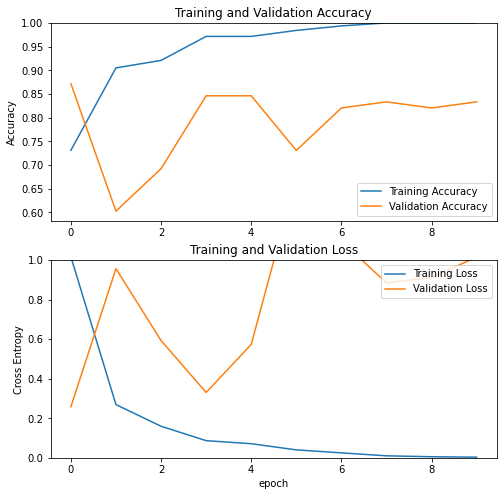

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model

### Un-freeze more layers

In [26]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [27]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 2,626,722
Trainable params: 2,230,178
Non-trainable params: 396,544
_________________________________________________________________


In [30]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 58


In [31]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
5/5 [==============================] - 48s 10s/step - loss: 0.1273 - accuracy: 0.9525 - val_loss: 1.0620 - val_accuracy: 0.8333
Epoch 2/5
5/5 [==============================] - 38s 8s/step - loss: 0.0308 - accuracy: 0.9905 - val_loss: 1.0795 - val_accuracy: 0.8333
Epoch 3/5
5/5 [==============================] - 38s 8s/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 1.1061 - val_accuracy: 0.8333
Epoch 4/5
5/5 [==============================] - 38s 8s/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 1.1369 - val_accuracy: 0.8333
Epoch 5/5
5/5 [==============================] - 39s 8s/step - loss: 0.0102 - accuracy: 0.9968 - val_loss: 1.1692 - val_accuracy: 0.8333


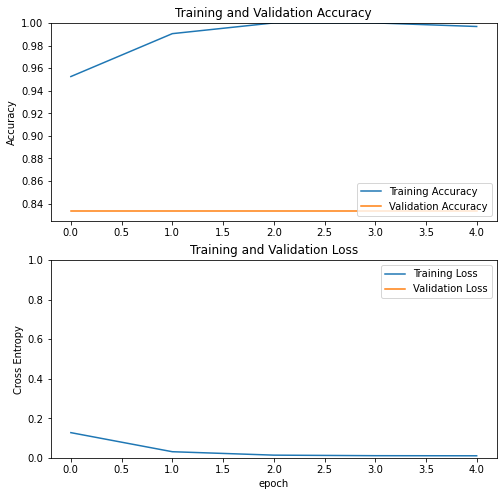

In [32]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Convert to TFLite

In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\JUNEHA~1\AppData\Local\Temp\tmpjzg48751\assets


INFO:tensorflow:Assets written to: C:\Users\JUNEHA~1\AppData\Local\Temp\tmpjzg48751\assets
C:\Users\June Han\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [37]:
'''
However, this .tflite file still uses floating-point values for the parameter data, and we need to fully 
quantize the model to int8 format.

To fully quantize the model, we need to perform post-training quantization with a representative 
dataset, which requires a few more arguments for the TFLiteConverter, and a function that builds a 
dataset that's representative of the training dataset.

So let's convert the model again with post-training quantization:
'''
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(syringe_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\JUNEHA~1\AppData\Local\Temp\tmpndkg90we\assets


INFO:tensorflow:Assets written to: C:\Users\JUNEHA~1\AppData\Local\Temp\tmpndkg90we\assets
C:\Users\June Han\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### Compare the accuracy

In [38]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 85.714%


Now let's check the accuracy of the `.tflite` file, using the same dataset.

However, there's no convenient API to evaluate the accuracy of a TensorFlow Lite model, so this code runs several inferences and compares the predictions against ground truth:

In [39]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('mobilenet_v2_1.0_224_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

Quant TF Lite accuracy: 85.714%
